# Real estate price model workflow

Sam Maurer, Feb 2018; Paul Waddell, June 2018

Python 3.6, intended to be backward compatible with 2.7

In [1]:
from __future__ import print_function
import warnings;warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

In [2]:
from scipy.stats import norm
%matplotlib inline

import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import seaborn as sns
sns.set()

In [3]:
# Standard to run UrbanSim from the root level of the project directory

import os; os.chdir('../..')

In [4]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import OLSRegressionStep
import orca

In [5]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [6]:
import datashader as ds
import holoviews as hv
import geoviews as gv

In [7]:
ds.__version__

'0.6.6'

## Explore the Orca registrations

In [ ]:
orca.list_tables()

In [ ]:
for table_name in orca.list_tables():
    print(table_name.upper())
    print(orca.get_table(table_name).to_frame().columns.tolist())
    print()

In [ ]:
orca.list_broadcasts()

In [ ]:
orca.list_steps()

## Explore the data

Orca doesn't execute code to load the registered objects until it needs to.

In [ ]:
orca.get_table('parcels').to_frame().describe()

In [ ]:
buildings = orca.get_table('buildings').to_frame()
buildings.describe()

## Generate accessibility measures for the price model

The network accessibility metrics are not stored on disk; for now we'll generate them using legacy code.

In [8]:
orca.run(['initialize_network_small'])

INFO:orca.orca:start: run step 'initialize_network_small'


Running step 'initialize_network_small'


INFO:orca.orca:finish: run step 'initialize_network_small'


Time to execute step 'initialize_network_small': 30.04 s
Total time to execute iteration 1 with iteration value None: 30.04 s


In [9]:
orca.run(['initialize_network_walk'])

INFO:orca.orca:start: run step 'initialize_network_walk'


Running step 'initialize_network_walk'


INFO:orca.orca:finish: run step 'initialize_network_walk'


Time to execute step 'initialize_network_walk': 106.08 s
Total time to execute iteration 1 with iteration value None: 106.08 s


In [10]:
orca.broadcast('nodessmall', 'rentals', cast_index=True, onto_on='node_id_small')
orca.broadcast('nodeswalk', 'rentals', cast_index=True, onto_on='node_id_walk')

In [ ]:
orca.run(['network_aggregations_small'])

In [12]:
orca.run(['network_aggregations_walk'])

INFO:orca.orca:start: run step 'network_aggregations_walk'
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk


Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = sqft_per_unit, node_id_walk


Computing sqft_unit_500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=sqft_per_unit
INFO:urbansim.utils.networks:    radius = 500, aggregation = ave, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, persons


Computing singles_500_walk


INFO:urbansim.utils.networks:    Filters = ['persons == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 52731 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, age_of_head


Computing elderly_hh_500_walk


INFO:urbansim.utils.networks:    Filters = ['age_of_head > 65']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 34788 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = children, node_id_walk


Computing children_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=children
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_sf_500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 1']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_mf_500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 3']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk


Computing pop_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing hh_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing poor_500_walk


INFO:urbansim.utils.networks:    Filters = ['income < 40000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 53660 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing rich_500_walk


INFO:urbansim.utils.networks:    Filters = ['income > 150000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 39177 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, tenure


Computing renters_500_walk


INFO:urbansim.utils.networks:    Filters = ['tenure == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 103635 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = income, node_id_walk


Computing avg_income_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=income
INFO:urbansim.utils.networks:    radius = 500, aggregation = ave, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing jobs_500_walk


INFO:urbansim.utils.networks:    dataframe = jobs, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = rent, node_id_walk
INFO:urbansim.utils.networks:    dataframe = rentals, varname=rent
INFO:urbansim.utils.networks:    radius = 500, aggregation = ave, decay = flat


Computing avg_rent_500_walk


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_white_500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_black_500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_asian_500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, hispanic_head


Computing pop_hisp_500_walk


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk


Computing units_1500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = sqft_per_unit, node_id_walk


Computing sqft_unit_1500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=sqft_per_unit
INFO:urbansim.utils.networks:    radius = 1500, aggregation = ave, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, persons


Computing singles_1500_walk


INFO:urbansim.utils.networks:    Filters = ['persons == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 52731 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, age_of_head


Computing elderly_hh_1500_walk


INFO:urbansim.utils.networks:    Filters = ['age_of_head > 65']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 34788 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = children, node_id_walk


Computing children_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=children
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_sf_1500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 1']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_mf_1500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 3']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk


Computing pop_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing hh_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing poor_1500_walk


INFO:urbansim.utils.networks:    Filters = ['income < 40000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 53660 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing rich_1500_walk


INFO:urbansim.utils.networks:    Filters = ['income > 150000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 39177 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, tenure


Computing renters_1500_walk


INFO:urbansim.utils.networks:    Filters = ['tenure == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 103635 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = income, node_id_walk


Computing avg_income_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=income
INFO:urbansim.utils.networks:    radius = 1500, aggregation = median, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing jobs_1500_walk


INFO:urbansim.utils.networks:    dataframe = jobs, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = rent, node_id_walk
INFO:urbansim.utils.networks:    dataframe = rentals, varname=rent
INFO:urbansim.utils.networks:    radius = 1500, aggregation = median, decay = flat


Computing avg_rent_1500_walk


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_white_1500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_black_1500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_asian_1500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, hispanic_head


Computing pop_hisp_1500_walk


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk


Computing pop_2500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_white_2500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_black_2500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_asian_2500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, hispanic_head


Computing pop_hisp_2500_walk


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:orca.orca:finish: run step 'network_aggregations_walk'


       units_500_walk  sqft_unit_500_walk  singles_500_walk  \
count   415716.000000       415716.000000     415716.000000   
mean       356.008972         1245.544556         89.887329   
std       1097.037720          979.879944        323.945648   
min          0.000000            0.000000          0.000000   
25%          9.000000          458.249519          1.000000   
50%        188.000000         1315.694275         28.000000   
75%        440.000000         1761.837921         86.000000   
max     184995.000000        30000.000000      45986.000000   

       elderly_hh_500_walk  children_500_walk  units_sf_500_walk  \
count        415716.000000      415716.000000      415716.000000   
mean             60.195038         161.779861         163.916275   
std             240.503342         448.370270         704.597778   
min               0.000000           0.000000           0.000000   
25%               1.000000           4.000000           2.000000   
50%              29.0000

In [14]:
nodeswalk = orca.get_table('nodeswalk').to_frame()

In [15]:
nodeswalk.to_csv('data/nodeswalk_vars.csv')

In [ ]:
orca.list_tables()

In [ ]:
print(orca.get_table('nodesdrive').to_frame().columns.tolist())

In [ ]:
nodesdrive = orca.get_table('nodesdrive').to_frame()

In [ ]:
nodessmall = orca.get_table('nodessmall').to_frame()

In [ ]:
from scipy.stats import norm
%matplotlib inline

import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import seaborn as sns
sns.set()

In [ ]:
plt.rcParams['figure.figsize']=8,8
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(nodessmall.med_income_10000, bins=500,  fit=norm, kde=False)

In [ ]:
print('{} nodes have median income zero or below'.format(len(nodessmall[nodessmall.med_income_10000 == -1])))

print('Total nodes count {}'.format(len (nodessmall)))

# Estimate a price model

The basic idea of the parcel template is that we create model steps by _passing arguments to classes_ rather than by writing Python functions and giving them Orca decorators, as we would for a fully custom model.

Much of the functionality for this is already built into UrbanSim and Orca, we'll just need to extend things here and there.

This demo uses a new RegressionStep() class that provides a full model development workflow: estimating a model, registering it with Orca, saving it for future use.

### Specify parameters and pass them to a model object

In [35]:
m = OLSRegressionStep()
m.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m.filters = 'redfin_sale_year > 2010 & residential_units == 1 & sqft_per_unit > 50'
m.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + year_built > 2010 + \
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) + \
    np.log(avg_income_500_walk+1) +\
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_25000 + 1) + \
    np.log(pop_2500_walk+1) + np.log(pop_black_2500_walk+1) + np.log(pop_hisp_2500_walk+1) + \
    np.log(pop_asian_2500_walk+1)  '
m.name = 'hedonic_price_sqft_single_family'
m.tags = ['paul', 'version 1']
m.fit()

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.311
Model:                                      OLS   Adj. R-squared:                  0.311
Method:                           Least Squares   F-statistic:                     4525.
Date:                          Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                                  22:54:48   Log-Likelihood:            -1.7544e+05
No. Observations:                        160286   AIC:                         3.509e+05
Df Residuals:                            160269   BIC:                         3.511e+05
Df Model:                                    16                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [37]:
buildings = orca.get_table('buildings').to_frame()
buildings['predicted_ln_price_sqft'] = 0.0
orca.add_table('buildings', buildings)
m.out_column = 'predicted_ln_price_sqft'
m.run()

In [41]:
buildings['predicted_price_sqft_sf'] = np.exp(buildings['predicted_ln_price_sqft']) - 1

In [42]:
buildings['residuals_price_sqft_sf'] = buildings.predicted_price_sqft - buildings.res_price_per_sqft

In [43]:
buildings[['res_price_per_sqft','predicted_price_sqft_sf','residuals_price_sqft_sf']][buildings.residential_units == 1].describe()

,res_price_per_sqft,predicted_price_sqft_sf,residuals_price_sqft_sf
count,1.418200e+06,1.418200e+06,1.418200e+06
mean,2.984734e+02,2.632624e+02,-3.521100e+01
std,2.037363e+02,1.385219e+02,1.898188e+02
min,0.000000e+00,-6.306730e-01,-5.007211e+04
25%,1.720888e+02,1.757738e+02,-9.511069e+01
50%,2.633638e+02,2.388858e+02,-1.977555e+01
75%,3.712024e+02,3.210489e+02,4.591868e+01
max,5.016109e+04,1.302269e+04,1.302269e+04


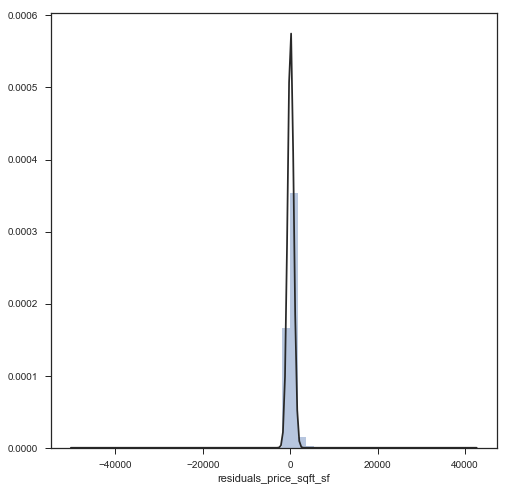

In [44]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(buildings.residuals_price_sqft_sf, fit=norm, kde=False)

In [52]:
m2 = OLSRegressionStep()
m2.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m2.filters = 'redfin_sale_year > 2010 & residential_units > 1 & sqft_per_unit > 50 & res_price_per_sqft < 5000'
m2.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + year_built > 2010 +\
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) +\
    np.log(avg_income_500_walk+1) +\
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_25000 + 1) + \
    np.log(pop_2500_walk+1) + np.log(pop_black_2500_walk+1) + np.log(pop_hisp_2500_walk+1) + \
    np.log(pop_asian_2500_walk+1) '
m2.name = 'hedonic_price_sqft_multi_family'
m2.tags = ['paul', 'version 1']
m2.fit()

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.357
Model:                                      OLS   Adj. R-squared:                  0.357
Method:                           Least Squares   F-statistic:                     1006.
Date:                          Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                                  23:10:06   Log-Likelihood:                -28648.
No. Observations:                         29016   AIC:                         5.733e+04
Df Residuals:                             28999   BIC:                         5.747e+04
Df Model:                                    16                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [53]:
buildings = orca.get_table('buildings').to_frame()
buildings['predicted_ln_price_sqft_mf'] = 0.0
orca.add_table('buildings', buildings)
m2.out_column = 'predicted_ln_price_sqft_mf'
m2.run()

In [54]:
buildings['predicted_price_sqft_mf'] = np.exp(buildings['predicted_ln_price_sqft_mf']) - 1

In [55]:
buildings['residuals_price_sqft_mf'] = buildings.predicted_price_sqft_mf - buildings.res_price_per_sqft

In [61]:
buildings[['res_price_per_sqft','predicted_price_sqft_mf','residuals_price_sqft_mf']][buildings.residential_units > 1].describe()

,res_price_per_sqft,predicted_price_sqft_mf,residuals_price_sqft_mf
count,297274.000000,297274.000000,297274.000000
mean,372.355890,290.421967,-81.933923
std,440.821092,157.799026,380.984332
min,0.000000,0.001653,-25965.837989
25%,168.864792,187.380096,-140.137816
50%,276.573207,251.875884,-27.423936
75%,443.358982,354.108242,62.440213
max,26233.219136,4139.747790,3597.754421


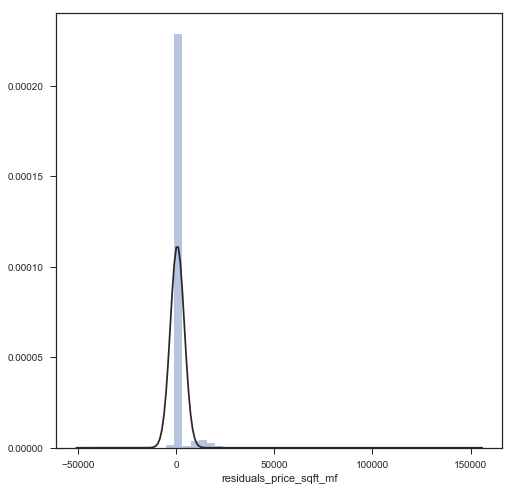

In [57]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(buildings.residuals_price_sqft_mf, fit=norm, kde=False)

In [23]:
m3 = OLSRegressionStep()
m3.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m3.filters = 'redfin_sale_year > 2010 & sqft_per_unit > 50'
m3.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + C(building_type_id) + \
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_1500_walk+1) + np.log(jobs_10000+1) + np.log(jobs_25000 + 1) + \
    np.log(pop_2500_walk+1) + np.log(pop_black_2500_walk+1) + np.log(pop_hisp_2500_walk+1) + \
    np.log(pop_asian_2500_walk+1) '
m3.name = 'hedonic_price_sqft_multi_family'
m3.tags = ['paul', 'version 1']
m3.fit()

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.424
Model:                                      OLS   Adj. R-squared:                  0.424
Method:                           Least Squares   F-statistic:                     5413.
Date:                          Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                                  22:42:19   Log-Likelihood:            -2.2577e+05
No. Observations:                        191518   AIC:                         4.516e+05
Df Residuals:                            191491   BIC:                         4.519e+05
Df Model:                                    26                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [ ]:
#    np.log(pop_10000+1) + np.log(pop_black_10000+1) + np.log(pop_hisp_10000+1) + \
#    np.log(pop_asian_10000+1) 

### If we like it, register it as an Orca step

In [ ]:
model.register()

In [ ]:
orca.list_steps()

### Run the Orca step

In [ ]:
orca.run(['RegressionStep-20180214-210159'])

### Check the fitted values

In [ ]:
df = orca.get_table('buildings').to_frame(['res_price_per_sqft', 'fitted_price'])
df.loc[df.fitted_price > 0].describe()

### BONUS

Running "model.register()" also registered the step with the new ModelManager extention, which saves it to disk so that it can be automatically re-loaded in the future.

The "test" model steps here were estimated earlier and loaded from disk. They're fully functional: we can run them in Orca, inspect the estimation results, etc.

In [ ]:
mm.list_steps()

In [ ]:
rs = mm.get_step('test-1')
type(rs)

In [ ]:
rs.model_expression

In [ ]:
rs.model.report_fit()